# Refining Semantic Segmentation Predictions Using a Second Model

This notebook takes predictions from a previously trained semantic segmentation model (the "first model") and uses a "second model" to refine and improve those predictions. The second model attempts to correct misclassifications and produce more accurate segmentation masks.

**Key Steps in this Notebook:**
1. Load the first model and generate its predictions on the training dataset.
2. Apply morphological operations and corrections to the first model's predictions.
3. Prepare data for the second model by combining the raw images and refined first-model predictions.
4. Train and evaluate the second model using a custom U-Net architecture with deep supervision.
5. Predict on the test set and create a submission file.


## Installation of Required Libraries

We first ensure that all necessary packages, including `albumentations`, `segmentation-models`, and `pydensecrf` are installed.


In [1]:
!pip install albumentations
!pip install segmentation-models
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ibh40da8
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ibh40da8
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=270354 sha256=b515997a1968ff5c0352f064db79a6106c8dfe72b9dbf305c517dbcd0d235f03
  Stored in directory: /tmp/pip-ephem-wheel-cache-ntno2_e2/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


## Import Libraries

Here we import the libraries for data handling, modeling, and image processing:
- TensorFlow/Keras for deep learning
- Albumentations for augmentation
- Segmentation Models for segmentation backbones and utilities
- CV2 for image processing
- Seaborn and Matplotlib for visualization


In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, BatchNormalization,
                                     Activation, Add, Concatenate, GlobalAveragePooling2D, Dense, Multiply, MaxPooling2D, Reshape)
import numpy as np
from sklearn.model_selection import train_test_split
from keras_cv.layers import RandomFlip, RandomRotation, RandomZoom
import tensorflow_probability as tfp
import keras_cv
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB3

import os
from datetime import datetime
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import cv2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Segmentation Models: using `tf.keras` framework.


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Dataset Description

We are dealing with Mars surface images of size 64x128 pixels. Each pixel is annotated with one of the following classes:
- Class 0: Background
- Class 1: Soil
- Class 2: Bedrock
- Class 3: Sand
- Class 4: Big Rock

We will load our training and test sets and later refine them for the second model.


## Import Data

### Load Cleaned Training Data

We load a pre-processed (cleaned) training set that has been prepared beforehand. This dataset includes images and their corresponding labels.


In [4]:
data_main = np.load("/kaggle/input/mars-dataset/cleaned_training_set.npz")
train_images, train_labels = data_main['images'], data_main['labels']

train_images.shape, train_labels.shape, train_images.max()

((2505, 64, 128), (2505, 64, 128), 254)

### Load Test Data

We also load the test data on which we will ultimately submit predictions. No labels are provided for the test set; we will apply our final model to generate segmentation masks.


In [5]:
# Load and clean data from the kaggle input
data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")
test = data['test_set']
image_ratio = test.shape[1] / test.shape[2]
test.shape, test.max(), data['training_set'].max()

((10022, 64, 128), 255, 254.0)

## Load the First Model

The first model is a pre-trained semantic segmentation model. We will use its predictions as a starting point. Our second model will then refine these predictions to produce improved segmentation maps.


In [6]:
def mean_IoU_model1(y_true, y_pred, num_classes=5):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.cast(y_pred, 'int32')
    y_true = K.cast(y_true, 'int32')
    iou = 0.0
    for c in range(num_classes):
        y_true_c = K.cast(K.equal(y_true, c), 'float32')
        y_pred_c = K.cast(K.equal(y_pred, c), 'float32')
        intersection = K.sum(y_true_c * y_pred_c)
        union = K.sum(y_true_c) + K.sum(y_pred_c) - intersection
        iou_class = (intersection + 1e-6) / (union + 1e-6)
        iou += iou_class
    mean_iou_value = iou / num_classes
    return mean_iou_value


def focal_loss_model1(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true_one_hot * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        loss = K.sum(loss, axis=-1)
        return loss

    return focal_loss_fixed
    
first_model = tf.keras.models.load_model(
    "/kaggle/input/mars-dataset/model_241213_130709.keras", 
    custom_objects={'mean_IoU': mean_IoU_model1, 'focal_loss_fixed': focal_loss_model1}
)
print("First model is loaded!")

First model is loaded!


## Generate Predictions from the First Model

We run the first model on the training images to get initial segmentation predictions. We then apply morphological operations to clean up these predictions.


In [7]:
X_train = np.expand_dims(train_images, axis=-1)
X_train = X_train.astype(np.float32) / 255.0

first_model_preds_temp = first_model.predict(X_train)[-1]
first_model_preds_temp = np.argmax(first_model_preds_temp, axis=-1)
print(f"Predictions shape: {first_model_preds_temp.shape}")

I0000 00:00:1734186764.555235     160 service.cc:145] XLA service 0x7ef720002400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734186764.555286     160 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734186764.555290     160 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/79 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step  

I0000 00:00:1734186774.133786     160 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step
Predictions shape: (2505, 64, 128)


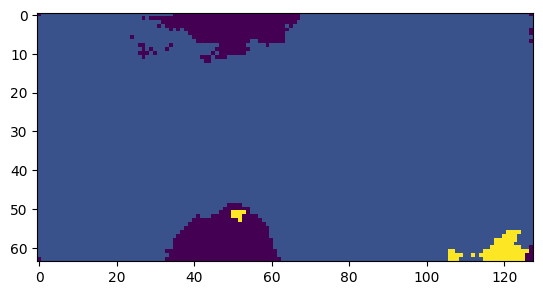

In [8]:
plt.imshow(first_model_preds_temp[24])

### Morphological Cleaning

We apply opening and closing operations to the predicted masks to remove small noise and fill small holes, improving the quality of the first model's predictions.


In [9]:
def apply_morphology(mask):
    kernel = np.ones((3,3), np.uint8)
    # Opening to remove small objects
    mask_clean = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    # Closing to fill small holes
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)
    return mask_clean

first_model_preds = np.empty_like(first_model_preds_temp)

# Iterate over each mask with a progress bar
for i in tqdm(range(first_model_preds_temp.shape[0]), desc="Processing Masks"):
    mask = first_model_preds_temp[i]
    first_model_pred = apply_morphology(mask)
    first_model_preds[i] = first_model_pred

Processing Masks: 100%|██████████| 2505/2505 [00:00<00:00, 16815.53it/s]


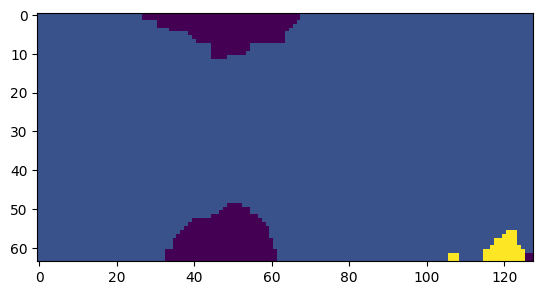

In [10]:
plt.imshow(first_model_preds[24])

# Preprocessing
making data ready for the second model

### Keeping Background classes only
because the first model was biased on this class

In [11]:
first_model_preds_signed = first_model_preds.astype(np.int16)
first_model_preds_background = np.where(first_model_preds_signed == 0, 0, -1)
print(first_model_preds_background.shape)
print(f"Unique values in first_model_preds_background: {np.unique(first_model_preds_background)}")

(2505, 64, 128)
Unique values in first_model_preds_background: [-1  0]


### Correcting Background Classes

If the first model incorrectly assigned the background class (0) where there should be another class, we fix this by using the ground-truth labels.


In [12]:
assert first_model_preds_background.shape == train_labels.shape, \
    f"Shape mismatch: first_model_preds_background.shape = {first_model_preds_background.shape}, train_labels.shape = {train_labels.shape}"

first_model_preds_background_corrected = first_model_preds_background.copy()
mask = (first_model_preds_background == 0) & (train_labels != 0)
first_model_preds_background_corrected[mask] = train_labels[mask]

print(f"Unique values in corrected masks: {np.unique(first_model_preds_background_corrected)}")

Unique values in corrected masks: [-1  0  1  2  3  4]


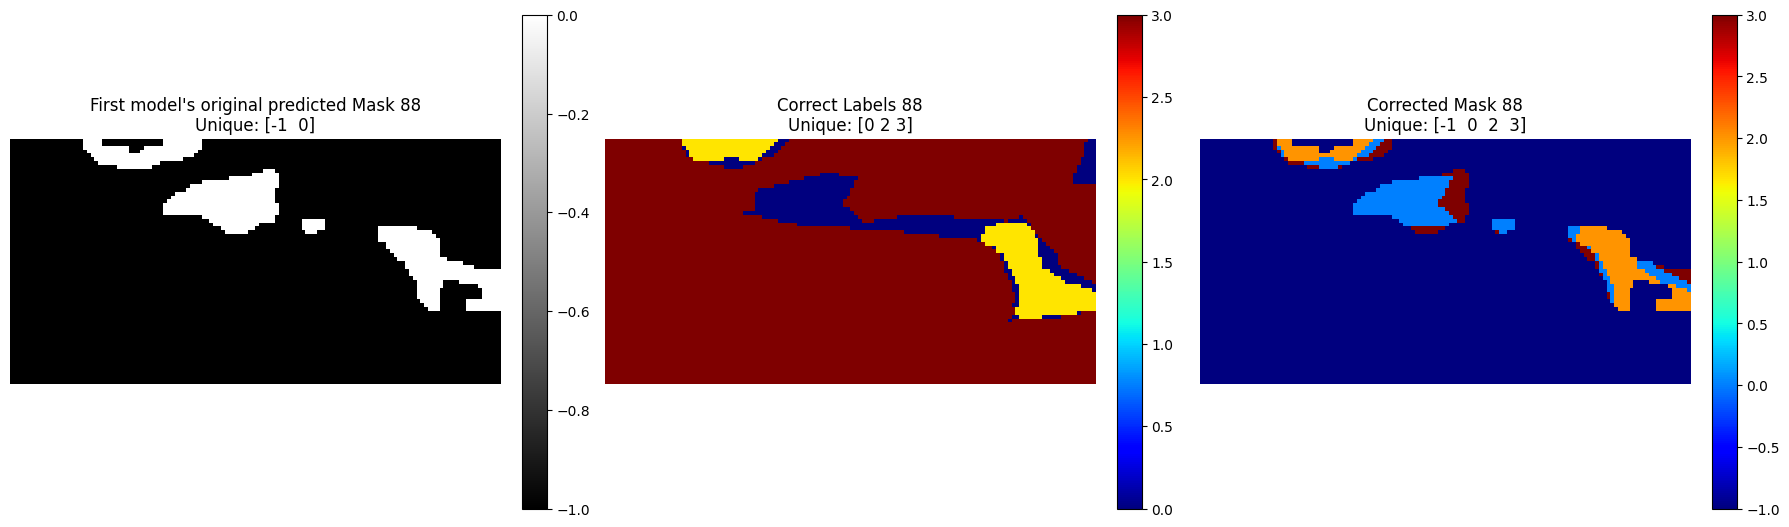

(2505, 64, 128)


In [13]:
def visualize_correction(index=0, 
                         first_model_preds_background=None, 
                         train_labels=None, 
                         corrected_masks=None):

    # Extract the masks for the given index
    original_mask = first_model_preds_background[index]
    label_mask = train_labels[index]
    corrected_mask = corrected_masks[index]
    
    # Compute unique values for each mask
    unique_original = np.unique(original_mask)
    unique_labels = np.unique(label_mask)
    unique_corrected = np.unique(corrected_mask)
    
    # Prepare titles with unique values
    title_original = f'First model\'s original predicted Mask {index}\nUnique: {unique_original}'
    title_labels = f'Correct Labels {index}\nUnique: {unique_labels}'
    title_corrected = f'Corrected Mask {index}\nUnique: {unique_corrected}'
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Display Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray', interpolation='none')
    axes[0].set_title(title_original)
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Display Train Labels
    im1 = axes[1].imshow(label_mask, cmap='jet', interpolation='none')
    axes[1].set_title(title_labels)
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Display Corrected Mask
    im2 = axes[2].imshow(corrected_mask, cmap='jet', interpolation='none')
    axes[2].set_title(title_corrected)
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

visualize_correction(index=88, 
                     first_model_preds_background=first_model_preds_background, 
                     train_labels=train_labels, 
                     corrected_masks=first_model_preds_background_corrected)

print(first_model_preds_background_corrected.shape)

## Data splitting and Preparation for the Second Model

We now combine:
- The original grayscale image (normalized)
- The cleaned background predictions from the first model

This gives us a two-channel input for the second model: one channel for the original image and one for the refined background. We then split the data into training and validatio. sets.


X_train Shape: (2129, 64, 128, 2)
X_valid Shape: (376, 64, 128, 2)
y_train Shape: (2129, 64, 128)
y_valid Shape: (376, 64, 128)
Class distributions in the training set:


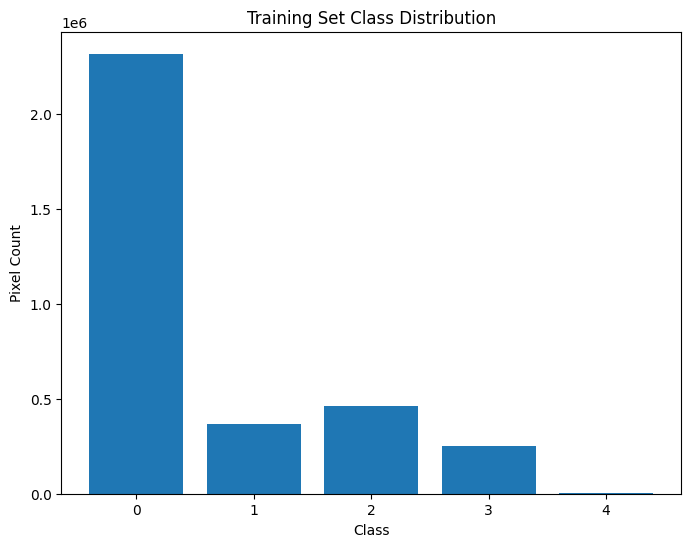

Class distributions in the validation set:


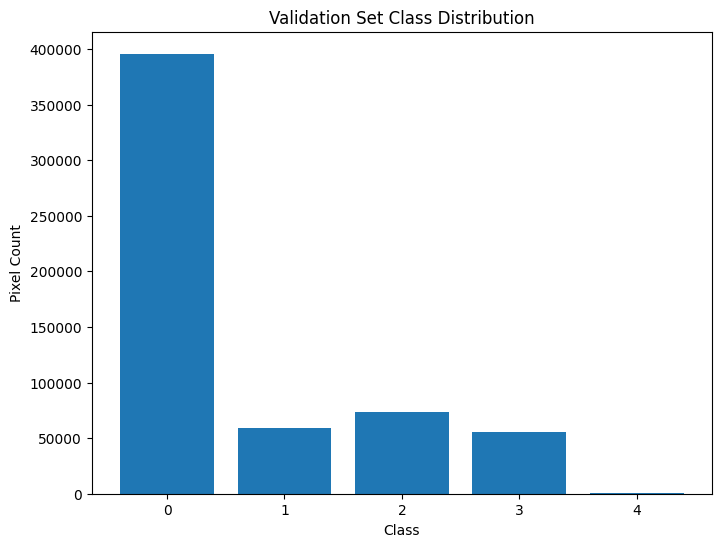

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def calculate_class_distributions(labels):
    distributions = []
    for label in labels:
        valid_pixels = label[label >= 0]
        dist = np.bincount(valid_pixels.ravel(), minlength=5)
        distributions.append(dist)
    return np.array(distributions)

def plot_class_distribution(labels, title):
    distributions = np.sum(calculate_class_distributions(labels), axis=0)
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(distributions)), distributions)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Pixel Count")
    plt.xticks(range(len(distributions)))
    plt.show()
    
train_images_temp = train_images.astype('float32') / 255.0
X = np.stack([train_images_temp, first_model_preds_background], axis=-1)
y = first_model_preds_background_corrected

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

# Print shapes
print("X_train Shape:", X_train.shape)
print("X_valid Shape:", X_valid.shape)
print("y_train Shape:", y_train.shape)
print("y_valid Shape:", y_valid.shape)

# Plot class distributions for sanity check
print("Class distributions in the training set:")
plot_class_distribution(y_train, "Training Set Class Distribution")

print("Class distributions in the validation set:")
plot_class_distribution(y_valid, "Validation Set Class Distribution")


## Augmentation

We apply data augmentation (flips, rotations, brightness/contrast changes) to increase the robustness of the second model. Validation data will not be augmented.


### Data Generator for the Second Model

We use a custom `Sequence` class (`MarsDataset`) that:
- Applies augmentations
- Prepares multi-level targets for deep supervision
- Supports batch-wise loading of data


In [15]:
class MarsDataset(Sequence):
    def __init__(self, images, masks, batch_size=16, augmentations=None, output_names=None, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augmentations if augmentations is not None else self.default_augment
        self.output_names = output_names if output_names is not None else ['final_output']

        # Define target sizes
        self.output_sizes = {
            'output_3': (16, 8),
            'output_2': (32, 16),
            'output_1': (64, 32),
            'final_output': (128, 64)
        }

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def default_augment(self, image, mask):
        return {'image': image, 'mask': mask}

    def resize_mask(self, mask, size):
        resized_mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
        return resized_mask

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks[idx * self.batch_size:(idx + 1) * self.batch_size]

        augmented = []
        for img, mask in zip(batch_x, batch_y):
            # img shape: (64,128,2), mask: (64,128)
            augmented_sample = self.augment(image=img, mask=mask)
            augmented.append((augmented_sample['image'], augmented_sample['mask']))

        # Now augmented images retain shape (64,128,2)
        batch_x_aug = np.array([item[0] for item in augmented])  # shape: (batch_size, 64,128,2)

        # Prepare targets for deep supervision outputs
        targets = {}
        for output_name in self.output_names:
            target_size = self.output_sizes.get(output_name, (64, 128))
            resized_masks = np.array([self.resize_mask(item[1], target_size) for item in augmented])
            targets[output_name] = resized_masks

        return batch_x_aug, targets


# Define augmentation pipeline (as before)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=60, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

output_names = ['output_3', 'output_2', 'output_1', 'final_output']
# Create Dataset instances with the class weights
train_dataset = MarsDataset(X_train, y_train, batch_size=32, augmentations=train_transform, output_names=output_names)
valid_dataset = MarsDataset(X_valid, y_valid, batch_size=32, augmentations=None, output_names=output_names)  # No augmentation for validation
print(y_valid.shape)

(376, 64, 128)


# Second Model: Custom U-Net with Deep Supervision and Gated Skip Connections

This model builds upon a U-Net architecture with the following enhancements:
- **Gated skip connections** to control the flow of encoder features.
- **Deep supervision** for improved gradient flow.
- **Focal loss** to handle class imbalance.

The input to this model is a 2-channel image (original + refined background).


## Create Model

In [16]:
# Building Blocks
def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def encoder_block(inputs, filters, pool=True):
    x = conv_block(inputs, filters)
    p = MaxPooling2D((2, 2))(x) if pool else x
    return x, p

# Gated Skip Connection
def gated_skip_connection_block(encoder_features, decoder_features, filters):
    # 1x1 Convolution to reduce channels for gating
    gate = Conv2D(1, (1,1), padding='same', activation='sigmoid')(encoder_features)
    # Multiply gate with encoder features
    gated_encoder = Multiply()([gate, encoder_features])
    # Optionally, process decoder features
    processed_decoder = Conv2D(filters, (1,1), padding='same', activation='relu')(decoder_features)
    # Combine gated encoder and processed decoder
    combined = Concatenate()([gated_encoder, processed_decoder])
    return combined

# Learnable Fusion Block
def learnable_fusion(encoder_features, decoder_features, filters):
    # Concatenate encoder and decoder features
    concat = Concatenate()([encoder_features, decoder_features])
    # Apply convolutional layers to learn the fusion
    fused = Conv2D(filters, (1,1), activation='relu')(concat)
    fused = Conv2D(filters, (3,3), padding='same', activation='relu')(fused)
    return fused

# Decoder Blocks
def decoder_block(inputs, skip_features, filters, skip_connection_type='concat'):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    
    if skip_connection_type == 'concat':
        x = Concatenate()([x, skip_features])
    elif skip_connection_type == 'add':
        x = Add()([x, skip_features])
    elif skip_connection_type == 'gated':
        x = gated_skip_connection_block(skip_features, x, filters)
    elif skip_connection_type == 'fusion':
        fused = learnable_fusion(skip_features, x, filters)
        x = Concatenate()([x, fused])
    else:
        raise ValueError("Unsupported skip connection type")
    
    x = conv_block(x, filters)
    return x

# Custom U-Net Model with Deep Supervision
def CustomUNet(input_shape=(64, 128, 1), num_classes=5, 
              skip_connection_type='gated', 
              backbone_filters=[64, 128, 256, 512],
              deep_supervision_levels=3):
    
    inputs = Input(input_shape)
    
    # Encoder
    skips = []
    x = inputs
    for f in backbone_filters:
        x, p = encoder_block(x, f)
        skips.append(x)
        x = p
    # Bottleneck
    x = conv_block(x, backbone_filters[-1]*2)
    
    # Decoder with Deep Supervision
    intermediate_outputs = []
    total_decoder_blocks = len(backbone_filters)
    for i, f in reversed(list(enumerate(backbone_filters))):
        x = decoder_block(x, skips[i], f, skip_connection_type=skip_connection_type)
        
        # Determine if this decoder block should have an intermediate output
        # For example, collect outputs from the last 'deep_supervision_levels' decoder blocks
        if (total_decoder_blocks - i) <= deep_supervision_levels:
            intermediate_output = Conv2D(num_classes, (1,1), activation='softmax', name=f'output_{i}')(x)
            intermediate_outputs.append(intermediate_output)
    
    # Final Output
    final_output = Conv2D(num_classes, (1, 1), activation='softmax', name='final_output')(x)
    
    # Combine all outputs
    outputs = intermediate_outputs + [final_output]
    
    model = Model(inputs, outputs)
    return model

# Instantiate the Custom U-Net Model with Deep Supervision
def efficientunet_custom(input_shape=(64, 128, 1), num_classes=5, skip_connection_type='gated', deep_supervision_levels=3):
    model = CustomUNet(input_shape=input_shape, 
                      num_classes=num_classes, 
                      skip_connection_type=skip_connection_type,
                      deep_supervision_levels=deep_supervision_levels)
    return model

# Configuration
SKIP_CONNECTION_TYPE = 'gated'  # Options: 'concat', 'add', 'gated', 'fusion'
# Instantiate the model
model = efficientunet_custom(input_shape=(64,128,2),
                             num_classes=5,
                             skip_connection_type=SKIP_CONNECTION_TYPE,
                             deep_supervision_levels=3)

num_params = model.count_params()
trainable_params = sum([tf.reduce_prod(var.shape).numpy() for var in model.trainable_variables])
non_trainable_params = sum([tf.reduce_prod(var.shape).numpy() for var in model.non_trainable_variables])
print(f"Total number of parameters: {num_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total number of parameters: 31409560
Trainable parameters: 31397784
Non-trainable parameters: 11776


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │      1,216 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,409,560 (119.82 MB)

 Trainable params: 31,397,784 (119.77 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Compile the Model

We compile the model with:
- Focal loss for each output
- Weighted losses for deep supervision outputs
- Mean IoU as a metric
- Adam optimizer with a chosen learning rate

Callbacks for early stopping and learning rate reduction are also employed.


In [18]:
# Learning Rate Reduction callback
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.6, 
    patience=7, 
    verbose=1, 
    min_lr=1e-6
)

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# Multi-Class IoU metric
def mean_IoU(y_true, y_pred, num_classes=5):
    # y_pred: probabilities; first get predicted class
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.cast(y_pred, 'int32')
    y_true = K.cast(y_true, 'int32')
    
    valid_mask = tf.not_equal(y_true, -1)
    valid_mask = tf.cast(valid_mask, 'float32')

    iou = 0.0
    for c in range(num_classes):
        y_true_c = K.cast(K.equal(y_true, c), 'float32')
        y_pred_c = K.cast(K.equal(y_pred, c), 'float32')
        
        intersection = K.sum(y_true_c * y_pred_c * valid_mask)
        union = (K.sum(y_true_c * valid_mask) + K.sum(y_pred_c * valid_mask) - intersection) + 1e-6
        iou_class = (intersection + 1e-6) / union
        iou += iou_class
    
    mean_iou_value = iou / num_classes
    return mean_iou_value



def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        # Ensure y_true is an integer
        y_true = tf.cast(y_true, tf.int32)
        
        # Create a mask for valid pixels
        valid_mask = tf.not_equal(y_true, -1)

        # Replace -1 with 0 for safe one-hot (won't affect valid_masked locations)
        y_true_safe = tf.where(valid_mask, y_true, tf.zeros_like(y_true))

        # One-hot encoding of y_true_safe
        num_classes = tf.shape(y_pred)[-1]
        y_true_one_hot = tf.one_hot(y_true_safe, depth=num_classes)

        epsilon = K.epsilon()
        y_pred_clipped = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true_one_hot * K.log(y_pred_clipped)
        weight = alpha * K.pow(1 - y_pred_clipped, gamma)
        loss = weight * cross_entropy
        loss = K.sum(loss, axis=-1)  # sum over classes

        valid_mask_float = tf.cast(valid_mask, tf.float32)
        loss_sum = tf.reduce_sum(loss * valid_mask_float, axis=[1, 2])
        valid_count = tf.reduce_sum(valid_mask_float, axis=[1, 2]) + 1e-6
        loss_mean = loss_sum / valid_count

        return loss_mean
    return focal_loss_fixed


loss_weights = {
    'output_1': 0.2,
    'output_2': 0.3,
    'output_3': 0.5,
    'final_output': 1.0  # Final output at (64, 128)
}

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss={
        'output_3': focal_loss(gamma=3., alpha=.25), 
        'output_2': focal_loss(gamma=3., alpha=.25), 
        'output_1': focal_loss(gamma=3., alpha=.25), 
        'final_output': focal_loss(gamma=3., alpha=.25)
    },
    loss_weights=loss_weights,
    metrics={
        'output_3': mean_IoU, 
        'output_2': mean_IoU, 
        'output_1': mean_IoU, 
        'final_output': mean_IoU
    }
)

## Training the Second Model

We now train the second model on the prepared dataset. Training can take several epochs. We will monitor validation loss and IoU to select the best model.


In [19]:
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=valid_dataset,
    callbacks=[lr_reducer, early_stopping]
)

Epoch 1/300


I0000 00:00:1734186838.895081     160 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_3', 8 bytes spill stores, 8 bytes spill loads



67/67 ━━━━━━━━━━━━━━━━━━━━ 106s 907ms/step - final_output_mean__io_u: 0.1672 - loss: 0.2477 - output_1_mean__io_u: 0.1932 - output_2_mean__io_u: 0.2195 - output_3_mean__io_u: 0.2193 - val_final_output_mean__io_u: 0.1410 - val_loss: 0.4674 - val_output_1_mean__io_u: 0.1523 - val_output_2_mean__io_u: 0.1602 - val_output_3_mean__io_u: 0.0825 - learning_rate: 5.0000e-04
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - final_output_mean__io_u: 0.2194 - loss: 0.1588 - output_1_mean__io_u: 0.2212 - output_2_mean__io_u: 0.2344 - output_3_mean__io_u: 0.2581 - val_final_output_mean__io_u: 0.2672 - val_loss: 0.1838 - val_output_1_mean__io_u: 0.2734 - val_output_2_mean__io_u: 0.2701 - val_output_3_mean__io_u: 0.1737 - learning_rate: 5.0000e-04
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - final_output_mean__io_u: 0.2316 - loss: 0.1623 - output_1_mean__io_u: 0.2379 - output_2_mean__io_u: 0.2627 - output_3_mean__io_u: 0.2831 - val_final_output_mean__io_u: 0.2672 - val_loss: 0.1733 -

## Training History

After training, we plot the training and validation loss and Mean IoU to visualize the model's learning progress over epochs.


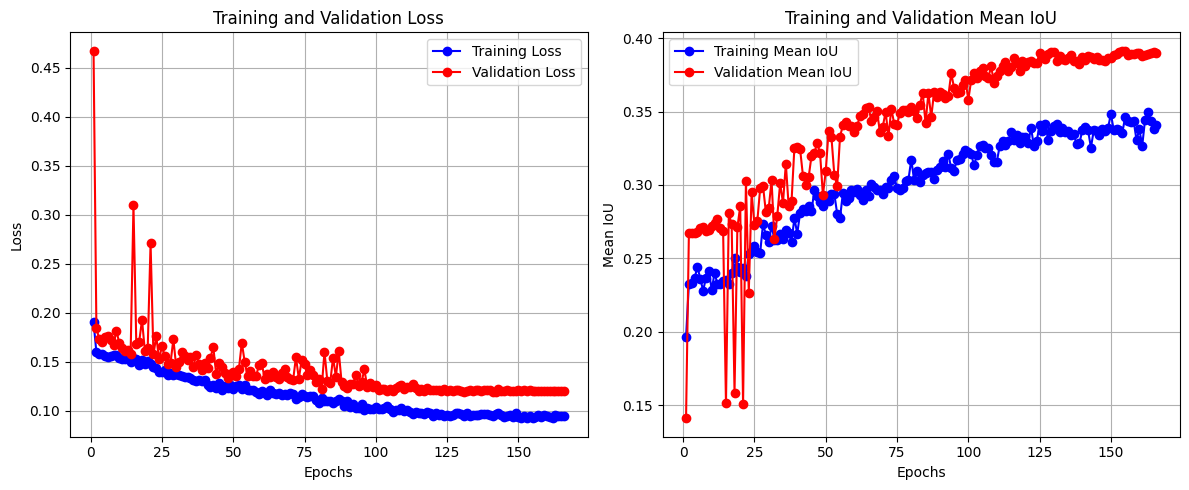

In [20]:
# Extract values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mean_iou = history.history['final_output_mean__io_u']
val_mean_iou = history.history['val_final_output_mean__io_u']

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Mean IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, train_mean_iou, 'bo-', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'ro-', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation and Confusion Matrix

We evaluate the model on the validation set to see final performance and produce a confusion matrix to understand per-class accuracy.


In [21]:
results = model.evaluate(valid_dataset, verbose=1)
print('validation loss:', results[0])
print('validation IoU:', results[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - final_output_mean__io_u: 0.3604 - loss: 0.1161 - output_1_mean__io_u: 0.3625 - output_2_mean__io_u: 0.3601 - output_3_mean__io_u: 0.3635
validation loss: 0.1189090684056282
validation IoU: 0.3850712776184082


#### Post processing

In [22]:
def apply_morphology(mask):
    kernel = np.ones((3,3), np.uint8)
    # Opening to remove small objects
    mask_clean = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    # Closing to fill small holes
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)
    return mask_clean

Confusion Matrix:
[[343080  19396  26982   6270      0]
 [ 25006  26875   5739   1150      0]
 [ 41545   9431  21978    922      0]
 [ 40016   3578   5088   7074      0]
 [   256      6    143     19      0]]


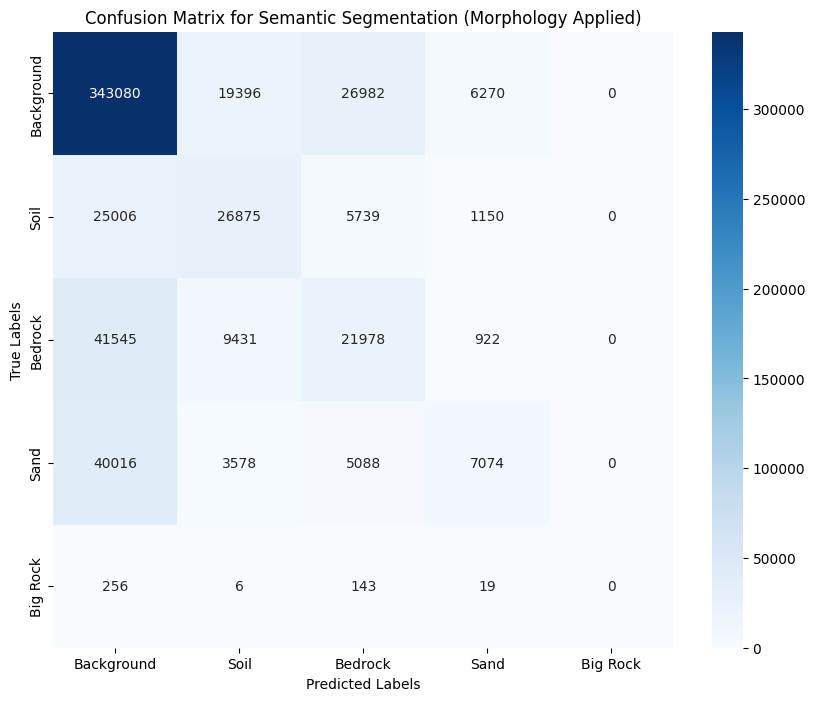

Classification Report:
Mean IoU value calculated manually: 0.25685677


In [23]:
class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']

def compute_confusion_matrix_and_classification_report(model, valid_dataset, apply_morph_flag):
    y_true = []
    y_pred = []
    num_batches = len(valid_dataset)
    
    for i in range(num_batches):
        batch_x, batch_y = valid_dataset[i]
        preds = model.predict(batch_x, verbose=0)
        final_preds = preds[-1]
        
        for b in range(final_preds.shape[0]):
            probs = final_preds[b]  # (H,W,C)
            true_mask = batch_y['final_output'][b]
            refined_mask = np.argmax(probs, axis=-1)
            
            # Apply morphological operation if requested
            if apply_morph_flag:
                refined_mask = apply_morphology(refined_mask)
            
            y_true.extend(true_mask.flatten())
            y_pred.extend(refined_mask.flatten())
    
    # Convert lists to tensors for mean IoU
    y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.int32)
    y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.int32)
    
    # Compute Mean IoU using TensorFlow's built-in function
    num_classes = len(class_names)
    m = tf.keras.metrics.MeanIoU(num_classes=num_classes)
    m.update_state(y_true_tensor, y_pred_tensor)
    mean_iou_value = m.result().numpy()
    
    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    
    return cm, mean_iou_value

# Example usage:
cm, mean_iou_value = compute_confusion_matrix_and_classification_report(
    model, 
    valid_dataset,
    apply_morph_flag=False
)

print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Semantic Segmentation (Morphology Applied)')
plt.show()

print("Classification Report:")
print('Mean IoU value calculated manually:', mean_iou_value)

In [24]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
# del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_152423.keras


In [25]:
second_model = tf.keras.models.load_model(
    model_filename, 
    custom_objects={'mean_IoU': mean_IoU, 'focal_loss_fixed': focal_loss}
)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_152423.keras


# Saving Predictions for final submission on Kaggle

## Predicting with first model and getting the predictions ready to be used in the second model!

In [26]:
X_test = np.expand_dims(test, axis=-1)
X_test = X_test.astype(np.float32) / 255.0

first_model_test_preds_temp = first_model.predict(X_test)[-1]
first_model_test_preds_temp = np.argmax(first_model_test_preds_temp, axis=-1)
print(f"Predictions shape: {first_model_test_preds_temp.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step
Predictions shape: (10022, 64, 128)


In [27]:
first_model_test_preds = np.empty_like(first_model_test_preds_temp)

for i in tqdm(range(first_model_test_preds_temp.shape[0])):
    mask = first_model_test_preds_temp[i]
    first_model_test_pred = apply_morphology(mask)
    first_model_test_preds[i] = first_model_test_pred

first_model_test_preds.shape

100%|██████████| 10022/10022 [00:00<00:00, 20098.71it/s]


(10022, 64, 128)

In [28]:
first_model_test_preds_signed = first_model_test_preds.astype(np.int16)
first_model_test_preds_background = np.where(first_model_test_preds_signed == 0, 0, -1)
print(first_model_test_preds_background.shape)
print(f"Unique values in first_model_test_preds_background: {np.unique(first_model_test_preds_background)}")

(10022, 64, 128)
Unique values in first_model_test_preds_background: [-1  0]


In [29]:
X_test_temp = test.astype(np.float32) / 255.0
X_testset = np.stack([X_test_temp, first_model_test_preds_background], axis=-1)
X_testset.shape

(10022, 64, 128, 2)

## Predicting with second model

In [30]:
second_model_test_preds_temp = second_model.predict(X_testset)[-1]
second_model_test_preds_temp = np.argmax(second_model_test_preds_temp, axis=-1)
print(f"Predictions shape: {second_model_test_preds_temp.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step
Predictions shape: (10022, 64, 128)


### Replacing corrected labels
Correcting the first model predictions with second model

In [31]:
mask = (first_model_test_preds_background == 0)
corrected_models_test_preds = np.where(mask, second_model_test_preds_temp, first_model_test_preds)
preds = corrected_models_test_preds
print(preds.shape)

(10022, 64, 128)


## Visualizing a sample result of two models

Text(0.5, 1.0, 'Final pred')

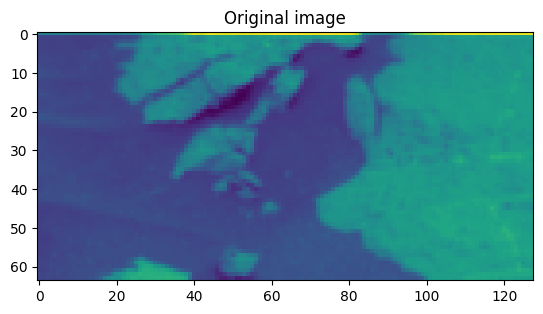

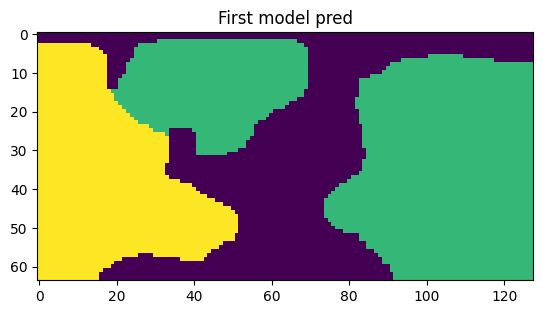

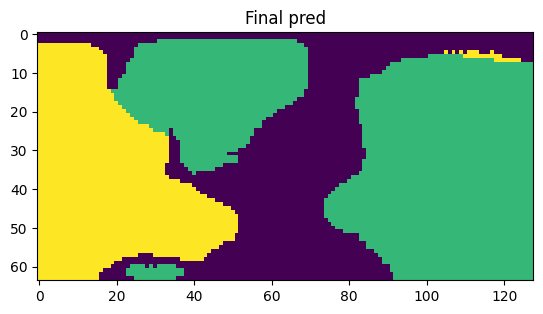

In [32]:
n= 11
plt.imshow(X_test[n])
plt.title("Original image")
plt.figure()
plt.imshow(first_model_test_preds[n])
plt.title("First model pred")
plt.figure()
plt.imshow(preds[n])
plt.title("Final pred")

## Submission Preparation

We convert the refined predictions into a CSV file according to the competition's submission requirements and package it into a ZIP file for submission.


In [33]:
import zipfile

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
zip_filename = submission_filename.replace(".csv", ".zip")
submission_df = y_to_df(preds)
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    with zipf.open(submission_filename, 'w') as csvfile:
        csvfile.write(submission_df.to_csv(index=False).encode('utf-8'))

print(f"ZIP file created: {zip_filename}")

ZIP file created: submission_241214_152423.zip
